In [28]:
#cell 1
import os
import random
import math
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

seed_everything(42)


Device: cuda


In [29]:
#cell 2
configs = {
    "small": {
        'img_size': 32, 'patch_size': 4, 'in_chans': 3, 'num_classes': 10,
        'embed_dim': 128, 'depth': 4, 'num_heads': 4, 'mlp_ratio': 4.0, 'dropout': 0.1,
        'batch_size': 128, 'test_batch_size': 256, 'epochs': 15, 'lr': 3e-4, 'weight_decay': 1e-4,
        'data_dir': './data'
    },
    "medium": {
        'img_size': 32, 'patch_size': 4, 'in_chans': 3, 'num_classes': 10,
        'embed_dim': 256, 'depth': 6, 'num_heads': 8, 'mlp_ratio': 4.0, 'dropout': 0.1,
        'batch_size': 128, 'test_batch_size': 256, 'epochs': 20, 'lr': 3e-4, 'weight_decay': 1e-4,
        'data_dir': './data'
    },
    "large": {
        'img_size': 32, 'patch_size': 4, 'in_chans': 3, 'num_classes': 10,
        'embed_dim': 384, 'depth': 8, 'num_heads': 12, 'mlp_ratio': 4.0, 'dropout': 0.1,
        'batch_size': 128, 'test_batch_size': 256, 'epochs': 25, 'lr': 3e-4, 'weight_decay': 1e-4,
        'data_dir': './data'
    }
}


Train size: 50000 Test size: 10000


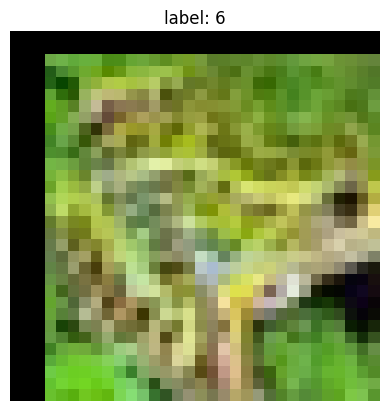

In [31]:
#cell 3
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

trainset = torchvision.datasets.CIFAR10(root=cfg['data_dir'], train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root=cfg['data_dir'], train=False, download=True, transform=transform_test)

trainloader = DataLoader(trainset, batch_size=cfg['batch_size'], shuffle=True, num_workers=2, pin_memory=True)
testloader = DataLoader(testset, batch_size=cfg['test_batch_size'], shuffle=False, num_workers=2, pin_memory=True)

print("Train size:", len(trainset), "Test size:", len(testset))

# Show one sample
images, labels = next(iter(trainloader))
img = images[0]
mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3,1,1)
std = torch.tensor([0.247, 0.243, 0.261]).view(3,1,1)
img_disp = img * std + mean
plt.imshow(img_disp.permute(1,2,0).numpy())
plt.title(f'label: {labels[0].item()}')
plt.axis('off')
plt.show()


In [32]:
#cell 4
class PatchEmbedding(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_chans=3, embed_dim=256):
        super().__init__()
        assert img_size % patch_size == 0
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2).transpose(1,2)
        return x

class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim=256, num_heads=8, dropout=0.0):
        super().__init__()
        self.mha = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout, batch_first=True)
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        attn_out, _ = self.mha(x, x, x)
        return self.norm(x + attn_out)

class MLPBlock(nn.Module):
    def __init__(self, embed_dim=256, mlp_ratio=4.0, dropout=0.0):
        super().__init__()
        hidden_dim = int(embed_dim * mlp_ratio)
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, embed_dim)
        self.drop = nn.Dropout(dropout)
        self.norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        out = self.fc2(F.gelu(self.fc1(x)))
        out = self.drop(out)
        return self.norm(x + out)

class TransformerEncoderLayer(nn.Module):
    def __init__(self, embed_dim=256, num_heads=8, mlp_ratio=4.0, dropout=0.0):
        super().__init__()
        self.attn = MultiHeadSelfAttention(embed_dim, num_heads, dropout)
        self.mlp = MLPBlock(embed_dim, mlp_ratio, dropout)

    def forward(self, x):
        x = self.attn(x)
        x = self.mlp(x)
        return x

class TransformerEncoder(nn.Module):
    def __init__(self, depth=6, embed_dim=256, num_heads=8, mlp_ratio=4.0, dropout=0.0):
        super().__init__()
        self.layers = nn.ModuleList([
            TransformerEncoderLayer(embed_dim, num_heads, mlp_ratio, dropout) for _ in range(depth)
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


In [35]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_chans=3, num_classes=10,
                 embed_dim=256, depth=6, num_heads=8, mlp_ratio=4.0, dropout=0.0):
        super().__init__()
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_chans, embed_dim)
        num_patches = self.patch_embed.num_patches
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        self.encoder = TransformerEncoder(depth, embed_dim, num_heads, mlp_ratio, dropout)
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes)
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def forward(self, x):
        B = x.size(0)
        x = self.patch_embed(x)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        x = self.encoder(x)
        x = self.norm(x)
        cls_out = x[:, 0]
        return self.head(cls_out)


In [36]:
#cell 6
def accuracy(output, target, topk=(1,)):
    with torch.no_grad():
        maxk = max(topk)
        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))
        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / target.size(0)).item())
        return res

def train_one_epoch(model, optimizer, criterion, dataloader, epoch):
    model.train()
    losses = 0.0
    pbar = tqdm(dataloader, desc=f'Train Ep {epoch}')
    for imgs, labels in pbar:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        losses += loss.item()
        pbar.set_postfix({'loss': losses / (pbar.n + 1)})
    return losses / len(dataloader)

def evaluate(model, dataloader, criterion):
    model.eval()
    total_loss = 0.0
    top1 = 0.0
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            a1 = accuracy(outputs, labels, topk=(1,))[0]
            top1 += a1 * (imgs.size(0) / len(dataloader.dataset))
    return total_loss / len(dataloader), top1


In [38]:
#cell 7
results = {}

for mode, cfg in configs.items():
    print("="*40)
    print(f" Training config: {mode.upper()} ")
    print("="*40)

    # Data loaders
    trainset = torchvision.datasets.CIFAR10(root=cfg['data_dir'], train=True, download=True,
                                            transform=transform_train)
    testset = torchvision.datasets.CIFAR10(root=cfg['data_dir'], train=False, download=True,
                                           transform=transform_test)
    trainloader = DataLoader(trainset, batch_size=cfg['batch_size'], shuffle=True, num_workers=2, pin_memory=True)
    testloader = DataLoader(testset, batch_size=cfg['test_batch_size'], shuffle=False, num_workers=2, pin_memory=True)

    # Model
    model = VisionTransformer(
        img_size=cfg['img_size'], patch_size=cfg['patch_size'], in_chans=cfg['in_chans'],
        num_classes=cfg['num_classes'], embed_dim=cfg['embed_dim'], depth=cfg['depth'],
        num_heads=cfg['num_heads'], mlp_ratio=cfg['mlp_ratio'], dropout=cfg['dropout']
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=cfg['lr'], weight_decay=cfg['weight_decay'])

    best_acc = 0.0
    for epoch in range(1, cfg['epochs'] + 1):
        train_loss = train_one_epoch(model, optimizer, criterion, trainloader, epoch)
        val_loss, val_acc = evaluate(model, testloader, criterion)
        print(f"Epoch {epoch}: TrainLoss={train_loss:.4f} ValLoss={val_loss:.4f} ValAcc={val_acc:.2f}%")
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save({'epoch': epoch, 'model_state': model.state_dict(), 'acc': best_acc},
                       out_dir / f'best_vit_{mode}.pth')

    results[mode] = best_acc
    print(f"Best Acc for {mode}: {best_acc:.2f}%")

print("\n==== Final Results ====")
for mode, acc in results.items():
    print(f"{mode.capitalize()}: {acc:.2f}%")



 Training config: SMALL 


Train Ep 1: 100%|██████████| 391/391 [00:22<00:00, 17.14it/s, loss=1.85]


Epoch 1: TrainLoss=1.8518 ValLoss=1.6568 ValAcc=39.28%


Train Ep 2: 100%|██████████| 391/391 [00:22<00:00, 17.27it/s, loss=1.48]


Epoch 2: TrainLoss=1.4736 ValLoss=1.3331 ValAcc=52.07%


Train Ep 3: 100%|██████████| 391/391 [00:22<00:00, 17.37it/s, loss=1.31]


Epoch 3: TrainLoss=1.3108 ValLoss=1.2117 ValAcc=56.36%


Train Ep 4: 100%|██████████| 391/391 [00:22<00:00, 17.63it/s, loss=1.2]


Epoch 4: TrainLoss=1.2023 ValLoss=1.1112 ValAcc=59.63%


Train Ep 5: 100%|██████████| 391/391 [00:23<00:00, 16.69it/s, loss=1.14]


Epoch 5: TrainLoss=1.1415 ValLoss=1.0592 ValAcc=61.96%


Train Ep 6: 100%|██████████| 391/391 [00:22<00:00, 17.74it/s, loss=1.08]


Epoch 6: TrainLoss=1.0789 ValLoss=1.0030 ValAcc=64.07%


Train Ep 7: 100%|██████████| 391/391 [00:22<00:00, 17.75it/s, loss=1.04]


Epoch 7: TrainLoss=1.0342 ValLoss=1.0020 ValAcc=64.36%


Train Ep 8: 100%|██████████| 391/391 [00:21<00:00, 17.83it/s, loss=0.987]


Epoch 8: TrainLoss=0.9870 ValLoss=0.9452 ValAcc=65.71%


Train Ep 9: 100%|██████████| 391/391 [00:22<00:00, 17.44it/s, loss=0.963]


Epoch 9: TrainLoss=0.9577 ValLoss=0.9250 ValAcc=66.91%


Train Ep 10: 100%|██████████| 391/391 [00:22<00:00, 17.16it/s, loss=0.93]


Epoch 10: TrainLoss=0.9248 ValLoss=0.8969 ValAcc=67.95%


Train Ep 11: 100%|██████████| 391/391 [00:23<00:00, 16.92it/s, loss=0.898]


Epoch 11: TrainLoss=0.8930 ValLoss=0.8385 ValAcc=69.99%


Train Ep 12: 100%|██████████| 391/391 [00:23<00:00, 16.99it/s, loss=0.866]


Epoch 12: TrainLoss=0.8611 ValLoss=0.8445 ValAcc=70.16%


Train Ep 13: 100%|██████████| 391/391 [00:22<00:00, 17.24it/s, loss=0.832]


Epoch 13: TrainLoss=0.8321 ValLoss=0.8365 ValAcc=70.31%


Train Ep 14: 100%|██████████| 391/391 [00:23<00:00, 16.84it/s, loss=0.806]


Epoch 14: TrainLoss=0.8064 ValLoss=0.7971 ValAcc=71.70%


Train Ep 15: 100%|██████████| 391/391 [00:22<00:00, 17.20it/s, loss=0.783]


Epoch 15: TrainLoss=0.7826 ValLoss=0.7973 ValAcc=71.82%
Best Acc for small: 71.82%
 Training config: MEDIUM 


Train Ep 1: 100%|██████████| 391/391 [00:43<00:00,  8.92it/s, loss=1.86]


Epoch 1: TrainLoss=1.8581 ValLoss=1.6401 ValAcc=39.56%


Train Ep 2: 100%|██████████| 391/391 [00:43<00:00,  8.98it/s, loss=1.46]


Epoch 2: TrainLoss=1.4574 ValLoss=1.3612 ValAcc=51.29%


Train Ep 3: 100%|██████████| 391/391 [00:43<00:00,  8.95it/s, loss=1.24]


Epoch 3: TrainLoss=1.2415 ValLoss=1.1556 ValAcc=58.43%


Train Ep 4: 100%|██████████| 391/391 [00:43<00:00,  8.94it/s, loss=1.13]


Epoch 4: TrainLoss=1.1300 ValLoss=1.1431 ValAcc=59.23%


Train Ep 5: 100%|██████████| 391/391 [00:43<00:00,  8.95it/s, loss=1.04]


Epoch 5: TrainLoss=1.0444 ValLoss=0.9694 ValAcc=65.32%


Train Ep 6: 100%|██████████| 391/391 [00:43<00:00,  8.93it/s, loss=0.975]


Epoch 6: TrainLoss=0.9749 ValLoss=0.9678 ValAcc=65.20%


Train Ep 7: 100%|██████████| 391/391 [00:43<00:00,  8.92it/s, loss=0.909]


Epoch 7: TrainLoss=0.9090 ValLoss=0.8808 ValAcc=69.09%


Train Ep 8: 100%|██████████| 391/391 [00:43<00:00,  8.95it/s, loss=0.863]


Epoch 8: TrainLoss=0.8627 ValLoss=0.8786 ValAcc=69.01%


Train Ep 9: 100%|██████████| 391/391 [00:43<00:00,  8.95it/s, loss=0.814]


Epoch 9: TrainLoss=0.8142 ValLoss=0.8763 ValAcc=69.89%


Train Ep 10: 100%|██████████| 391/391 [00:43<00:00,  8.97it/s, loss=0.772]


Epoch 10: TrainLoss=0.7718 ValLoss=0.7999 ValAcc=72.18%


Train Ep 11: 100%|██████████| 391/391 [00:43<00:00,  8.96it/s, loss=0.735]


Epoch 11: TrainLoss=0.7355 ValLoss=0.7640 ValAcc=72.89%


Train Ep 12: 100%|██████████| 391/391 [00:43<00:00,  8.94it/s, loss=0.698]


Epoch 12: TrainLoss=0.6977 ValLoss=0.7185 ValAcc=74.64%


Train Ep 13: 100%|██████████| 391/391 [00:43<00:00,  8.95it/s, loss=0.662]


Epoch 13: TrainLoss=0.6620 ValLoss=0.6768 ValAcc=76.06%


Train Ep 14: 100%|██████████| 391/391 [00:43<00:00,  8.93it/s, loss=0.642]


Epoch 14: TrainLoss=0.6420 ValLoss=0.6704 ValAcc=76.25%


Train Ep 15: 100%|██████████| 391/391 [00:43<00:00,  8.95it/s, loss=0.608]


Epoch 15: TrainLoss=0.6081 ValLoss=0.7046 ValAcc=75.44%


Train Ep 16: 100%|██████████| 391/391 [00:43<00:00,  8.97it/s, loss=0.586]


Epoch 16: TrainLoss=0.5862 ValLoss=0.6468 ValAcc=77.50%


Train Ep 17: 100%|██████████| 391/391 [00:43<00:00,  8.93it/s, loss=0.563]


Epoch 17: TrainLoss=0.5631 ValLoss=0.6107 ValAcc=78.28%


Train Ep 18: 100%|██████████| 391/391 [00:43<00:00,  8.96it/s, loss=0.536]


Epoch 18: TrainLoss=0.5363 ValLoss=0.6758 ValAcc=76.77%


Train Ep 19: 100%|██████████| 391/391 [00:43<00:00,  8.95it/s, loss=0.523]


Epoch 19: TrainLoss=0.5225 ValLoss=0.6141 ValAcc=79.14%


Train Ep 20: 100%|██████████| 391/391 [00:43<00:00,  8.91it/s, loss=0.5]


Epoch 20: TrainLoss=0.5000 ValLoss=0.6219 ValAcc=78.36%
Best Acc for medium: 79.14%
 Training config: LARGE 


Train Ep 1: 100%|██████████| 391/391 [01:49<00:00,  3.58it/s, loss=1.97]


Epoch 1: TrainLoss=1.9740 ValLoss=1.7398 ValAcc=32.71%


Train Ep 2: 100%|██████████| 391/391 [01:49<00:00,  3.59it/s, loss=1.64]


Epoch 2: TrainLoss=1.6399 ValLoss=1.4880 ValAcc=45.45%


Train Ep 3: 100%|██████████| 391/391 [01:49<00:00,  3.58it/s, loss=1.4]


Epoch 3: TrainLoss=1.3960 ValLoss=1.3286 ValAcc=52.72%


Train Ep 4: 100%|██████████| 391/391 [01:49<00:00,  3.57it/s, loss=1.25]


Epoch 4: TrainLoss=1.2509 ValLoss=1.1892 ValAcc=57.66%


Train Ep 5: 100%|██████████| 391/391 [01:49<00:00,  3.57it/s, loss=1.16]


Epoch 5: TrainLoss=1.1586 ValLoss=1.1560 ValAcc=58.74%


Train Ep 6: 100%|██████████| 391/391 [01:49<00:00,  3.58it/s, loss=1.06]


Epoch 6: TrainLoss=1.0637 ValLoss=0.9778 ValAcc=65.97%


Train Ep 7: 100%|██████████| 391/391 [01:49<00:00,  3.57it/s, loss=0.998]


Epoch 7: TrainLoss=0.9978 ValLoss=0.9847 ValAcc=65.74%


Train Ep 8: 100%|██████████| 391/391 [01:49<00:00,  3.57it/s, loss=0.94]


Epoch 8: TrainLoss=0.9397 ValLoss=0.9131 ValAcc=67.91%


Train Ep 9: 100%|██████████| 391/391 [01:49<00:00,  3.57it/s, loss=0.885]


Epoch 9: TrainLoss=0.8855 ValLoss=0.8672 ValAcc=70.05%


Train Ep 10: 100%|██████████| 391/391 [01:49<00:00,  3.57it/s, loss=0.838]


Epoch 10: TrainLoss=0.8378 ValLoss=0.8188 ValAcc=71.63%


Train Ep 11: 100%|██████████| 391/391 [01:49<00:00,  3.57it/s, loss=0.804]


Epoch 11: TrainLoss=0.8043 ValLoss=0.8162 ValAcc=71.54%


Train Ep 12: 100%|██████████| 391/391 [01:49<00:00,  3.57it/s, loss=0.77]


Epoch 12: TrainLoss=0.7698 ValLoss=0.8180 ValAcc=72.12%


Train Ep 13: 100%|██████████| 391/391 [01:49<00:00,  3.58it/s, loss=0.738]


Epoch 13: TrainLoss=0.7375 ValLoss=0.7511 ValAcc=74.19%


Train Ep 14: 100%|██████████| 391/391 [01:49<00:00,  3.57it/s, loss=0.706]


Epoch 14: TrainLoss=0.7063 ValLoss=0.7425 ValAcc=74.12%


Train Ep 15: 100%|██████████| 391/391 [01:49<00:00,  3.57it/s, loss=0.683]


Epoch 15: TrainLoss=0.6828 ValLoss=0.7118 ValAcc=75.78%


Train Ep 16: 100%|██████████| 391/391 [01:49<00:00,  3.57it/s, loss=0.653]


Epoch 16: TrainLoss=0.6527 ValLoss=0.7073 ValAcc=75.69%


Train Ep 17: 100%|██████████| 391/391 [01:49<00:00,  3.56it/s, loss=0.629]


Epoch 17: TrainLoss=0.6292 ValLoss=0.6902 ValAcc=76.95%


Train Ep 18: 100%|██████████| 391/391 [01:49<00:00,  3.57it/s, loss=0.617]


Epoch 18: TrainLoss=0.6175 ValLoss=0.6651 ValAcc=77.19%


Train Ep 19: 100%|██████████| 391/391 [01:49<00:00,  3.57it/s, loss=0.592]


Epoch 19: TrainLoss=0.5925 ValLoss=0.6466 ValAcc=78.16%


Train Ep 20: 100%|██████████| 391/391 [01:49<00:00,  3.56it/s, loss=0.58]


Epoch 20: TrainLoss=0.5797 ValLoss=0.6364 ValAcc=78.09%


Train Ep 21: 100%|██████████| 391/391 [01:49<00:00,  3.57it/s, loss=0.559]


Epoch 21: TrainLoss=0.5592 ValLoss=0.6246 ValAcc=78.78%


Train Ep 22: 100%|██████████| 391/391 [01:49<00:00,  3.57it/s, loss=0.54]


Epoch 22: TrainLoss=0.5399 ValLoss=0.6190 ValAcc=79.09%


Train Ep 23: 100%|██████████| 391/391 [01:49<00:00,  3.56it/s, loss=0.52]


Epoch 23: TrainLoss=0.5197 ValLoss=0.6652 ValAcc=78.38%


Train Ep 24: 100%|██████████| 391/391 [01:49<00:00,  3.57it/s, loss=0.507]


Epoch 24: TrainLoss=0.5072 ValLoss=0.6492 ValAcc=79.02%


Train Ep 25: 100%|██████████| 391/391 [01:49<00:00,  3.57it/s, loss=0.487]


Epoch 25: TrainLoss=0.4870 ValLoss=0.6189 ValAcc=79.65%
Best Acc for large: 79.65%

==== Final Results ====
Small: 71.82%
Medium: 79.14%
Large: 79.65%


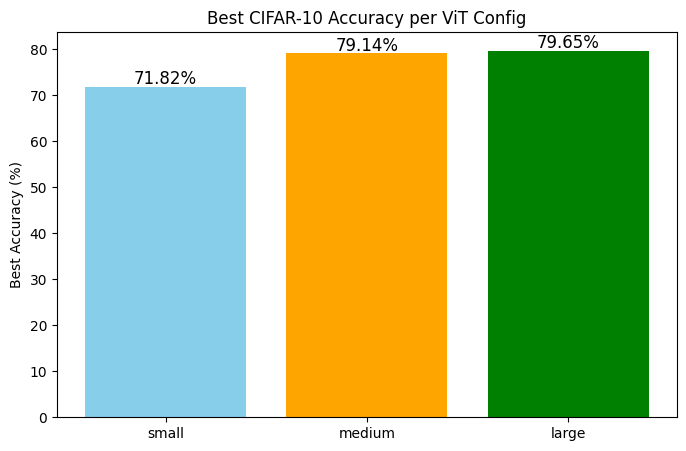

In [40]:
modes = list(results.keys())
accs = [results[m] for m in modes]

plt.figure(figsize=(8,5))
plt.bar(modes, accs, color=['skyblue', 'orange', 'green'])
plt.ylabel("Best Accuracy (%)")
plt.title("Best CIFAR-10 Accuracy per ViT Config")
for i, v in enumerate(accs):
    plt.text(i, v + 0.5, f"{v:.2f}%", ha='center', fontsize=12)
plt.show()
